## LOAD MODULES

In [1]:
#import modules
import xarray as xr
import numpy as np
import pandas as pd
import salem
import plotly.graph_objects as go

import sys
sys.path.append('/exports/csce/datastore/geos/users/s1878599/python_code/')
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st, IGP as igp

import warnings
warnings.filterwarnings('ignore')

#for getting only pib data
import salem
shdf= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/IGP.shp")

In [2]:
#import modules
from load_main import *
import sys
sys.path.append('/exports/csce/datastore/geos/users/s1878599/python_code/')
from Air_Quality_notebooks import utils as utl
from WRFChemToolkit.analysis import statistics as st

## Create functions for calculating emissions 

In [3]:
def calc_hour_emibio(ds,sres):
    """
    Convert isopr+pinenes emissions rate mol km^-2 hr^-1 to hourly emission at each gridpoint Tg hr-1.
    """
    #t_res time resoluton of outputs
    gTg=1e-12 #g to Kg
    mw_isp = 68  # g/ml molar weight of isoprene
    mw_pin =136.24 # molar weight of pinenes

    ds["tot_emi_BISOP"]=ds["MEBIO_ISOP"]*mw_isp*(sres**2)*gTg
    ds["tot_emi_PIN"]=(ds["MEBIO_APIN"] +ds["MEBIO_BPIN"])*mw_pin*(sres*sres)*gTg
    ds["tot_emibio"]= ds["tot_emi_BISOP"]  #+ds["tot_emi_PIN"]
    
    ds["tot_emi_BISOP"].attrs["units"]="Tg hour^-1"
    ds["tot_emi_PIN"].attrs["units"]="Tg hour^-1"
    ds["tot_emibio"].attrs["units"]="Tg hour^-1"

In [4]:
# load outputs data
oab_pth='/geos/d21/s1878599/IGP/outputs/autumn/wrfout_d01_2017-11-01_00:00:00_.nc'
owb_pth='/geos/d21/s1878599/IGP/outputs/winter/wrfout_d01_2018-01-22_00:00:00_.nc'
omb_pth='/geos/d21/s1878599/IGP/outputs/monsoon/wrfout_d01_2017-07-17_00:00:00_.nc'
opmb_pth='/geos/d21/s1878599/IGP/outputs/premonsoon/wrfout_d01_2017-05-02_00:00:00.nc'

oap_pth='/geos/d21/s1878599/wrfout_d01_2017-11-01_00:00:00_isop.nc'
owp_pth='/geos/d21/s1878599/wrfout_d01_2018-01-22_00:00:00_isop.nc'
omp_pth='/geos/d21/s1878599/wrfout_d01_2017-07-17_00:00:00_isop.nc'
opmp_pth='/geos/d21/s1878599/wrfout_d01_2017-05-02_00:00:00_isop.nc'

oab= xr.open_mfdataset(oab_pth).sel(Time=slice(1,16)) # get period from 1 nov to 8 nov without 
oap=xr.open_mfdataset(oap_pth).sel(Time=slice(1,16))  # output perturbed from antrho
owb= xr.open_mfdataset(owb_pth).sel(Time=slice(1,16)) # get period from 22 jan to 29 nov
owp=xr.open_mfdataset(owp_pth).sel(Time=slice(1,16))  # output perturbed from antrho
opmb= xr.open_mfdataset(opmb_pth).sel(Time=slice(1,16)) # get period from 2 may to 8 may
opmp=xr.open_mfdataset(opmp_pth).sel(Time=slice(1,16))  # output perturbed from antrho
omb=xr.open_mfdataset(omb_pth).sel(Time=slice(1,16)) # get period from 17 july to 24 july
omp=xr.open_mfdataset(omp_pth).sel(Time=slice(1,16)) # output perturbed from fire

In [5]:
# put everything in a dict by season
bout={"aut":[oab,oap], "win":[owb,owp],"pmon":[opmb,opmp],"mon":[omb,omp]}

In [6]:
bout['aut'][0].MEBIO_ISOP

<xarray.DataArray 'MEBIO_ISOP' (Time: 15, south_north: 119, west_east: 159)>
dask.array<getitem, shape=(15, 119, 159), dtype=float32, chunksize=(15, 119, 159), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(15, 119, 159), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(15, 119, 159), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(15,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  MEGAN2 isoprene emiss
    units:        mol km^-2 hr^-1
    stagger:

In [7]:
#Calculate total emissions at each gridpoint at each output time step. [Tg]
t_res =3 # output frequency in h.
for v in bout.values(): # v is list of datasets.
    for ds in v: 
        calc_hour_emibio(ds,sres=20)
        ds["tot_emibio"]=ds["tot_emibio"]*t_res #ouputs are every 3 hours: need to multiply by 3 each  emission output

In [8]:
u= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/U_IGP.shp")
m= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/M_IGP.shp")
l= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/L_IGP.shp")
shp={'upp':u,'mid':m,'low':l}

In [9]:
emi={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in bout.keys():
    for k in shp.keys():
        v0igp=bout[s][0].salem.roi(shape=shp[k])
        v1igp=bout[s][1].salem.roi(shape=shp[k])
        tb= (v0igp['tot_emibio'].sum(dim=['Time','south_north','west_east'])).values  
        tp= (v1igp['tot_emibio'].sum(dim=['Time','south_north','west_east'])).values
        d=tp-tb # difference Tg
        emi[s].update({k:d})

In [10]:
emi['mon']

{'upp': 0.0003459705, 'mid': 0.00023604976, 'low': 0.00030724658}

In [11]:
# create masks
def create_masks(ds,shp,emi):
    masks={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
    for s in emi.keys():
        for k in shp.keys():
            ds.PM2_5_DRY.values=(emi[s][k])*np.ones(ds.PM2_5_DRY.shape) 
            t=ds.salem.roi(shape=shp[k])  
            np.nan_to_num(t.PM2_5_DRY.values, copy=False, nan=1, posinf=0.0, neginf=0.0)
            m=t.PM2_5_DRY[0,0,:,:]
            masks[s].update({k:m})
    return masks

In [12]:
ds= xr.open_mfdataset('/geos/d21/s1878599/IGP/outputs/autumn/wrfout_d01_2017-11-01_00:00:00_.nc')
emimsk=create_masks(ds,shp,emi)

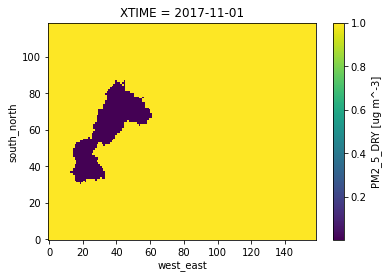

In [13]:
emimsk['pmon']['upp'].plot()

## Prepare aerosols outputs

In [14]:
# get aerosol data ALL DOMAIN
oab_pth='/geos/d21/s1878599/IGP/outputs/autumn/wrfout_d01_2017-11-01_00:00:00_.nc'
oap_pth='/geos/d21/s1878599/wrfout_d01_2017-11-01_00:00:00_isop.nc'
owb_pth='/geos/d21/s1878599/IGP/outputs/winter/wrfout_d01_2018-01-22_00:00:00_.nc'
owp_pth='/geos/d21/s1878599/wrfout_d01_2018-01-22_00:00:00_isop.nc'
opmb_pth='/geos/d21/s1878599/IGP/outputs/premonsoon/wrfout_d01_2017-05-02_00:00:00.nc'
opmp_pth='/geos/d21/s1878599/wrfout_d01_2017-05-02_00:00:00_isop.nc'
omb_pth='/geos/d21/s1878599/IGP/outputs/monsoon/wrfout_d01_2017-07-17_00:00:00_.nc'
omp_pth='/geos/d21/s1878599/wrfout_d01_2017-07-17_00:00:00_isop.nc'

oab= xr.open_mfdataset(oab_pth).sel(Time=slice(1,16)) # get period from 1 nov to 8 nov without 
oap=xr.open_mfdataset(oap_pth).sel(Time=slice(1,16))  # output perturbed from antrho
owb= xr.open_mfdataset(owb_pth).sel(Time=slice(1,16)) # get period from 22 jan to 29 nov
owp=xr.open_mfdataset(owp_pth).sel(Time=slice(1,16))  # output perturbed from antrho
opmb= xr.open_mfdataset(opmb_pth).sel(Time=slice(1,16)) # get period from 2 may to 8 may
opmp=xr.open_mfdataset(opmp_pth).sel(Time=slice(1,16))  # output perturbed from antrho
omb=xr.open_mfdataset(omb_pth).sel(Time=slice(1,16)) # get period from 17 july to 24 july
omp=xr.open_mfdataset(omp_pth).sel(Time=slice(1,16)) # output perturbed from fire

In [15]:
# put everything in a dict by season
# put everything in a dict by season
sbout={"aut":[oab,oap], "win":[owb,owp],"pmon":[opmb,opmp],"mon":[omb,omp]}

In [16]:
#get aerosols for each dataset
aaer={}
for k,v in sbout.items():
    
    baer= aer.get_aerosols(v[0])
    baer.attrs=v[0].attrs
    paer= aer.get_aerosols(v[1])
    paer.attrs=v[1].attrs
    
    aaer.update({k : [baer,paer]})

## Calculate sensitivities

In [17]:
#Create function for surface sensitivity at gridpoint ij for a specified species.


def get_s_ij(bds,pds,delta_emi,var):
    """
    bds = base output
    pds = perturbed output
    delta_emi = total difference in emissions [ug/m3]
    var = variable for which calculate sensitivity.
    """
    # surface total difference in concentration over sim period [ug/m3]
    diff_var = (pds[var]-bds[var]).sum('Time')[0, :, :]
    diff_var = diff_var.clip(min=0.0)
    np.nan_to_num(diff_var, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    s = (diff_var/delta_emi['upp']/delta_emi['mid']/delta_emi['low']) #divide by local emissions
    return xr.Dataset({"sty":s},coords=dict(delta_emi['upp'].coords))

# calculate sensitivities for all season and put in a dict
def sensitivity(do,de,var):
    "do= output dict,de=emissions dict var=varname "
    shdfigp= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/IGP.shp")
    s={}
    for k in do.keys():
        
        sens= get_s_ij(do[k][0],do[k][1],de[k],var) # calc sensitivity
        sens.attrs=do[k][0].attrs 
        sens_igp = sens.salem.roi(shape=shdfigp)  # get sensitivity only for IGP
        s.update({k:[sens_igp,sens]})

    return s

In [18]:
# calculate sensitivities for PM2.5
spm25=sensitivity(aaer,emimsk,"pm25_tot")

In [19]:
# calculate sensitivities for POA
sPOA=sensitivity(aaer,emimsk,"pm10_POA")

In [20]:
# calculate sensitivities for SOA
sSOA=sensitivity(aaer,emimsk,"pm10_SOA")

In [21]:
# calculate sensitivities for OA
sOA=sensitivity(aaer,emimsk,"pm10_OA")

## PLOTS

In [29]:
#SPATIAL PLOT IGP

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

def set_formatter(axes):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
        gl.ylocator = mticker.FixedLocator([20,25,30,35])
        
        ax.add_feature(cfeature.COASTLINE, lw=0.5)
        ax.add_feature(cfeature.BORDERS, lw=0.5)
        
    # get lon values only n the last ax
        if ax==axes[3]:
            gl.xlabels_bottom = True
    
    
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=1, lw=0.5)
            


def sensplot(lat,lon,pmds,mds,ads,wds,vmin=0,vmax=None, title=None, label=None, cmap="OrRd",levs=10, 
            figsize=[7, 10],format="%.2f",save=False,spath=None,name="plot",savef='pdf', dpi=100):

    fig, axes =plt.subplots(nrows=4,ncols=1,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    igp_shp="/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/IGP.shp"
    shp_path=(igp_shp,igp_shp,igp_shp,igp_shp)
    
    set_formatter(axes.flatten())
    set_admin(axes.flatten(), shp_path)
 
    #Getting values.
    
    vpm=pmds[:,:].values #.clip(min=0)
    #np.nan_to_num(vpm, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    vm= mds[:,:].values.clip(min=0,max=0)
    #np.nan_to_num(vm, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    va= ads[:,:].values #.clip(min=0)
    #np.nan_to_num(va, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    vw= wds[:,:].values #.clip(min=0)
    #np.nan_to_num(vw, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
   
    import math
    if vmax is None:  # Get the max value in the array to plot.
        vmax =np.array([np.nanmax(vpm),np.nanmax(vm),np.nanmax(va),np.nanmax(vw)]).max() 
      
    print(vmin,vmax)
    levels = np.linspace(vmin, vmax, levs)  # number of levels for which divide the bar. Customise 
    print(levels)
    
    # premonsoon
    cspm=axes[0].contourf(lon,lat,vpm,transform=ccrs.PlateCarree(),cmap=cmap, vmin=vmin,vmax=vmax,levels=levels,
                           extend="both")#,locator=mticker.LogLocator())
    cspm.cmap.set_over("#800000")
    cspm.cmap.set_under('#000080')
                                                 
    # monsoon
    csm=axes[1].contourf(lon,lat,vm,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=levels,
                          extend="both")#,locator=mticker.LogLocator()) 
    csm.cmap.set_over("#800000")
    csm.cmap.set_under("#000080")
    #autumn
    csa=axes[2].contourf(lon,lat,va,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=levels,
                          extend="both")#,locator=mticker.LogLocator()) 
    csa.cmap.set_over("#800000")
    csa.cmap.set_under("#000080")
    #winter
    csw=axes[3].contourf(lon,lat,vw,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=levels,
                          extend="both")#,locator=mticker.LogLocator()) 
    csw.cmap.set_over("#800000")
    csw.cmap.set_under("#000080")
    
 
    axes[0].text(-0.15, 0.55, 'PRE-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[0].transAxes)
    axes[1].text(-0.15, 0.55, 'MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[1].transAxes)
    axes[2].text(-0.15, 0.55, 'POST-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[2].transAxes)
    axes[3].text(-0.15, 0.55, 'WINTER', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[3].transAxes)
    
    fig.subplots_adjust(right=0.8,hspace=0.4)  
    cbar_ax = fig.add_axes([0.85, 0.1, 0.05, 0.8])  #[left, bottom, width, height]
    cbar= fig.colorbar(csw, cax=cbar_ax,pad=0.35,shrink=1, format=format)
    cbar.set_label(label,fontsize=13)
    cbar.ax.tick_params(labelsize='medium')

    if title is not None:
        axes[0].set_title(title, fontsize=12,pad=20)
    
    fig.tight_layout()
    
    #save
    if save:
        plt.savefig( spath + name +'.' + savef, format=savef, dpi=dpi)
    
    fig.show()

5 5000.0
[   5.          267.89473684  530.78947368  793.68421053 1056.57894737
 1319.47368421 1582.36842105 1845.26315789 2108.15789474 2371.05263158
 2633.94736842 2896.84210526 3159.73684211 3422.63157895 3685.52631579
 3948.42105263 4211.31578947 4474.21052632 4737.10526316 5000.        ]


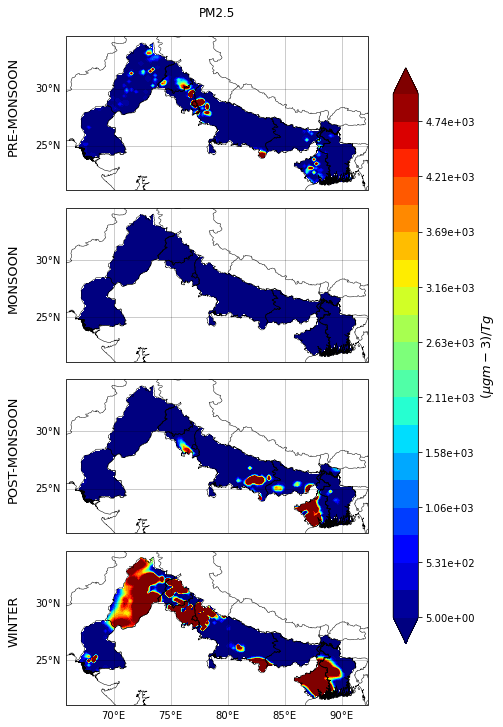

In [35]:
#Plot
lon =spm25["aut"][0].XLONG[:, :]
lat =spm25["aut"][0].XLAT[:, :]

sensplot(lat,lon,spm25["pmon"][0].sty,spm25["mon"][0].sty,spm25["aut"][0].sty,spm25["win"][0].sty,cmap="jet",vmin=5,vmax=5e3,label="$(\mu g m-3)/Tg$",title="PM2.5",
        levs=20,format="%.2e",figsize=[7,10],save=False) #label="$(\mu g m-3)$"

5 5000.0
[   5.          267.89473684  530.78947368  793.68421053 1056.57894737
 1319.47368421 1582.36842105 1845.26315789 2108.15789474 2371.05263158
 2633.94736842 2896.84210526 3159.73684211 3422.63157895 3685.52631579
 3948.42105263 4211.31578947 4474.21052632 4737.10526316 5000.        ]


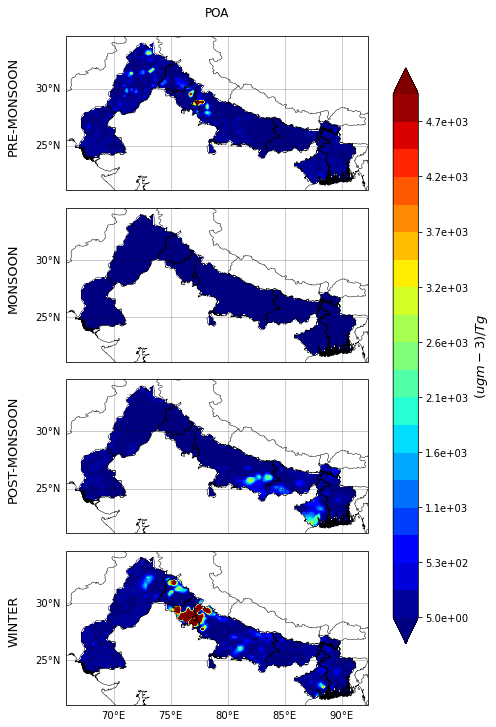

In [36]:
#label="$(\mu g m-3)$"
#Tg
sensplot(lat,lon,sPOA["pmon"][0].sty,sPOA["mon"][0].sty,sPOA["aut"][0].sty,sPOA["win"][0].sty,cmap="jet",vmin=5,vmax=5e3,label="$(ug m-3)/Tg$", title="POA",
        levs=20,format="%.1e",figsize=[7,10],save=False,name="sens_POA",savef='pdf', dpi=100)

5 5000.0
[   5.          267.89473684  530.78947368  793.68421053 1056.57894737
 1319.47368421 1582.36842105 1845.26315789 2108.15789474 2371.05263158
 2633.94736842 2896.84210526 3159.73684211 3422.63157895 3685.52631579
 3948.42105263 4211.31578947 4474.21052632 4737.10526316 5000.        ]


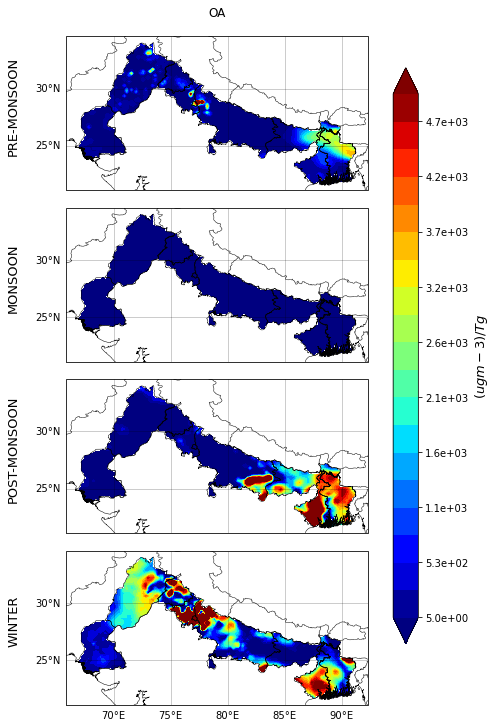

In [37]:
sensplot(lat,lon,sOA["pmon"][0].sty,sOA["mon"][0].sty,sOA["aut"][0].sty,sOA["win"][0].sty,cmap="jet", vmin=5,vmax=5e3,label='$(ug m-3)/Tg$',title="OA",
        levs=20,format="%.1e",figsize=[7,10],save=False,name="sens_OA",savef='pdf', dpi=100)

5 5000.0
[   5.          267.89473684  530.78947368  793.68421053 1056.57894737
 1319.47368421 1582.36842105 1845.26315789 2108.15789474 2371.05263158
 2633.94736842 2896.84210526 3159.73684211 3422.63157895 3685.52631579
 3948.42105263 4211.31578947 4474.21052632 4737.10526316 5000.        ]


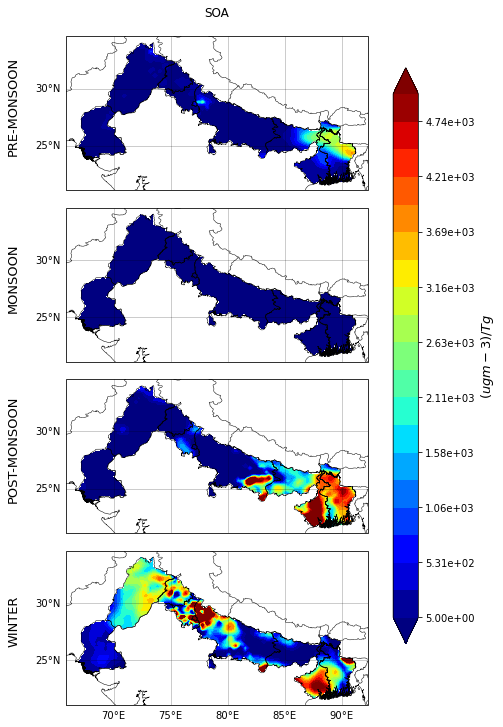

In [38]:
sensplot(lat,lon,sSOA["pmon"][0].sty,sSOA["mon"][0].sty,sSOA["aut"][0].sty,sSOA["win"][0].sty,cmap="jet",vmin=5,vmax=5e3, label='$(ug m-3)/Tg$',title="SOA",
        levs=20,format="%.2e",figsize=[7,10],name="sens_OA",savef='pdf', dpi=100)